In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00


In [ ]:
%cd "/content/gdrive/MyDrive/DL07/Project1"

/content/gdrive/MyDrive/DL07/Project1


In [2]:
import pandas as pd
import numpy as np
import re
import regex
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA

from underthesea import word_tokenize, pos_tag, sent_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from os import truncate
# Bước 1: đọc dữ liệu
data = pd.read_excel("Reviews.xlsx")

In [ ]:
data.head(3)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8417 entries, 0 to 8416
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           8417 non-null   int64 
 1   Company Name                 8417 non-null   object
 2   Cmt_day                      8417 non-null   object
 3   Title                        8417 non-null   object
 4   What I liked                 8416 non-null   object
 5   Suggestions for improvement  8412 non-null   object
 6   Rating                       8417 non-null   int64 
 7   Salary & benefits            8417 non-null   int64 
 8   Training & learning          8417 non-null   int64 
 9   Management cares about me    8417 non-null   int64 
 10  Culture & fun                8417 non-null   int64 
 11  Office & workspace           8417 non-null   int64 
 12  Recommend?                   8417 non-null   object
dtypes: int64(7), object(6)
memory usa

In [ ]:
data['text'] = data['Title'].fillna('') + '- '+ data['What I liked'].fillna('')+'- '+ data['Suggestions for improvement'].fillna('')

# Làm sạch dữ liệu

In [ ]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 49.3 MB/s eta 0:00:00


In [ ]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
#print(teen_dict)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
englist_lst = file.read().split('\n')
for line in englist_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [ ]:
def process_text(text, dict_emoji, dict_teen, lst_wrong):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    document = re.sub(r'(.)\1+', r'\1', text) # thay thế lònggggg --> lòng
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(dict_emoji[word]+' ' if word in dict_emoji else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words
        sentence = ' '.join('' if word in lst_wrong else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

# Chuẩn hóa Unicode Tiếng Việt

In [ ]:
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

# Tạo từ đặc biệt ráp lại với nhau

In [ ]:
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

# Postag

In [ ]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

# Remove Stopword

In [ ]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [ ]:
data['clean'] = data['text'].apply(lambda x : process_text(str(x) , emoji_dict, teen_dict, wrong_lst ))\
                            .apply(lambda x : covert_unicode(str(x)))\
                            .apply(lambda x : process_special_word(str(x)))\
                            .apply(lambda x : remove_stopword(str(x), stopwords_lst))\
                            .apply(lambda x: process_postag_thesea(str(x)))
data['clean'].head(5)

,clean
0,thoải_mái thoải_mái hybrid thỏa_thuận tốt đủ c...
1,năng_động_Cơ_sở trẻ dự_án thể nghiên_cứu maping
2,thoải_mái vẻ giúp_đỡ lẫn chuyên_nghiệp Khá yêu...
3,learn yên_tĩnh flexible teams forcus evaluate
4,đẹp vật_chất tốt đồng_nghiệp Đồng_nghiệp vẻ th...


In [ ]:
data.Rating.value_counts()

,count
Rating,
5,3510
4,2698
3,1639
2,446
1,124


Rating 4, 5 --> hài lòng\
3 --> trung tính\
1,2 --> không hài lòng

In [ ]:
data['sentiment'] = np.where(data['Rating'] >= 4 ,2, np.where(data['Rating'] >= 3,1,0 ))


In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
2,6208
1,1639
0,570


# Vẽ WordCloud

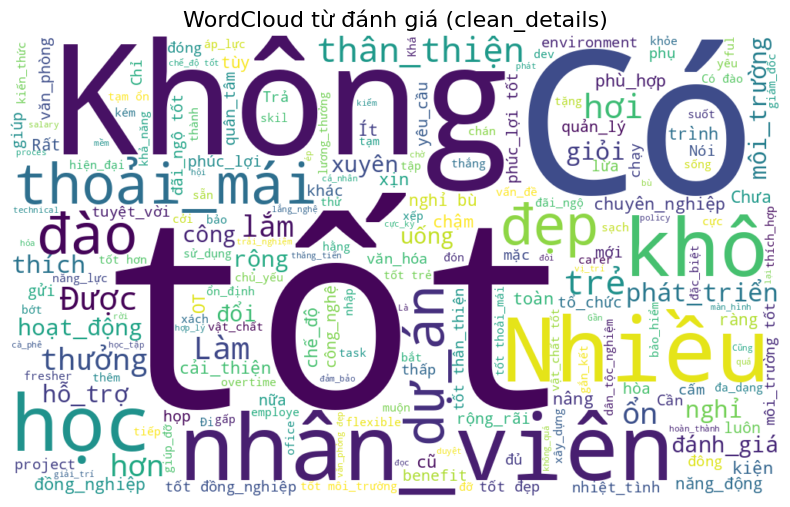

In [ ]:
text = " ".join(data["clean"].dropna().astype(str).tolist())

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white"
).generate(text)

# Hiển thị WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud từ đánh giá (clean)", fontsize=16)
plt.show()

In [ ]:
#Vector hóa CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix = vectorizer.fit_transform(data["clean"])
doc_term_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 80853 stored elements and shape (8417, 4163)>

In [ ]:
# Bước 4: Huấn luyện LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_matrix = lda.fit_transform(doc_term_matrix)

In [ ]:
lda_matrix

array([[0.57907168, 0.3799623 , 0.01371125, 0.01359055, 0.01366422],
       [0.83822659, 0.04058095, 0.04055314, 0.04020242, 0.04043689],
       [0.27672726, 0.0205353 , 0.48879744, 0.19370846, 0.02023154],
       ...,
       [0.0067838 , 0.05523564, 0.00674458, 0.00676258, 0.9244734 ],
       [0.01193932, 0.01194939, 0.01186161, 0.80670644, 0.15754324],
       [0.56367113, 0.01096867, 0.40393532, 0.01077749, 0.01064739]])

# Xác định x ,y

In [ ]:
X = doc_term_matrix
y = data['sentiment']

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import  classification_report

# Dùng mô hình Naive Bayes

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state= 42)

In [ ]:
model = MultinomialNB()

In [ ]:
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:

acc = accuracy_score(y_test,y_pred)

print('acc ', acc)

acc  0.734362628661916


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  20,   65,   97],
       [  14,  145,  326],
       [  31,  138, 1690]])

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.308     0.110     0.162       182
           1      0.417     0.299     0.348       485
           2      0.800     0.909     0.851      1859

    accuracy                          0.734      2526
   macro avg      0.508     0.439     0.454      2526
weighted avg      0.691     0.734     0.705      2526



# **Kết quả dự đoán thuộc nhóm 2 rất cao(tích cực) \**
# **--> các class thuộc nhóm 0 và 1 tỷ lệ đúng rất thấp**

# Xây dựng model Logistic Regression

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state= 42)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
print(model.intercept_)
print(model.coef_[0])

[-0.20193778  0.31593109 -0.11399332]
[-1.10152483e-01 -3.16714071e-02 -2.95897473e-02 ... -6.14153313e-02
 -2.96206431e-04  3.76215885e-01]


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Đánh giá mô hình

acc = accuracy_score(y_test,y_pred)

print('acc ', acc)

acc  0.734362628661916


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  20,   65,   97],
       [  14,  145,  326],
       [  31,  138, 1690]])

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.308     0.110     0.162       182
           1      0.417     0.299     0.348       485
           2      0.800     0.909     0.851      1859

    accuracy                          0.734      2526
   macro avg      0.508     0.439     0.454      2526
weighted avg      0.691     0.734     0.705      2526



# **Cũng như mô hình Navie Byes**
# **Kết quả dự đoán thuộc nhóm 2 rất cao(tích cực)**
# **--> các class thuộc nhóm 0 và 1 tỷ lệ đúng rất thấp**

# Sử dụng over_sampling tăng mẫu lên

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Tách feature và label
X = data.drop(columns=['sentiment'])
y = data['sentiment']

# Khởi tạo oversampler – chỉ oversample lớp 0- 2000, 1 - 3000
oversample = RandomOverSampler(sampling_strategy={0: 2000, 1: 3000}, random_state=42)

# Tạo dữ liệu mới sau khi oversample
X_resampled, y_resampled =  oversample.fit_resample(X, y)

# Kiểm tra lại phân phối sau khi xử lý
print("Phân phối ban đầu:", Counter(y))
print("Phân phối sau khi oversample:", Counter(y_resampled))

Phân phối ban đầu: Counter({2: 6208, 1: 1639, 0: 570})
Phân phối sau khi oversample: Counter({2: 6208, 1: 3000, 0: 2000})


In [ ]:
vectorizer1 = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix1 = vectorizer.fit_transform(X_resampled["clean"])
doc_term_matrix1

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 111586 stored elements and shape (11208, 5620)>

In [ ]:
X1 = doc_term_matrix1
y1= y_resampled

In [ ]:
X_train1 , X_test1 , y_train1, y_test1 = train_test_split(X1, y1, random_state=42)

# Thử lại Với model Navie Beys

In [ ]:
nvmodel = MultinomialNB()

In [ ]:
nvmodel.fit(X_train1, y_train1)

MultinomialNB()

In [ ]:
y_pred_nv = nvmodel.predict(X_test1)

In [ ]:
acc = accuracy_score(y_test1,y_pred_nv)
print('acc ', acc)

acc  0.7391149179157744


In [ ]:
cm = confusion_matrix(y_test1, y_pred_nv)
cm

array([[ 319,   81,  115],
       [  43,  364,  321],
       [  40,  131, 1388]])

In [ ]:
print(classification_report(y_test1, y_pred_nv, digits=3))

              precision    recall  f1-score   support

           0      0.794     0.619     0.696       515
           1      0.632     0.500     0.558       728
           2      0.761     0.890     0.821      1559

    accuracy                          0.739      2802
   macro avg      0.729     0.670     0.692      2802
weighted avg      0.733     0.739     0.729      2802



# **Sau khi thay đổi mẫu, F1 của các class đều tăng**

# Thử lại model Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression
lgmodel = LogisticRegression(class_weight='balanced', max_iter=1000)
lgmodel.fit(X_train1,y_train1)
print(model.intercept_)
print(model.coef_[0])

[-0.39123011  0.34266304  0.04856707]
[-0.07583681 -0.03502537 -0.04198498 ... -0.1876452   0.05714815
  0.31031072]


In [ ]:
y_pred1 = lgmodel.predict(X_test1)

In [ ]:
# Đánh giá mô hình
acc = accuracy_score(y_test1, y_pred1)
print('acc ', acc)

acc  0.7662384011420414


In [ ]:
cm = confusion_matrix(y_test1, y_pred1)
cm

array([[ 458,   33,   24],
       [  48,  525,  155],
       [  88,  307, 1164]])

In [ ]:
print(classification_report(y_test1, y_pred1, digits=3))

              precision    recall  f1-score   support

           0      0.771     0.889     0.826       515
           1      0.607     0.721     0.659       728
           2      0.867     0.747     0.802      1559

    accuracy                          0.766      2802
   macro avg      0.748     0.786     0.762      2802
weighted avg      0.782     0.766     0.769      2802



# **Acc trong model Logistic cũng tăng đáng kể trong các class**

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knnModel = KNeighborsClassifier(n_neighbors=5)
knnModel.fit(X_train1, y_train1)

KNeighborsClassifier()

In [ ]:
y_pred = knnModel.predict(X_test1)
score = accuracy_score(y_test1,y_pred)
precision = precision_score(y_test1,y_pred,average='macro')
recall = recall_score(y_test1,y_pred,average='macro')
acc = accuracy_score(y_test1,y_pred)
print(score, recall, precision, acc)

0.5945753033547466 0.612810726683199 0.609424929750162 0.5945753033547466


In [ ]:
print(classification_report(y_test1, y_pred1, digits=3))

              precision    recall  f1-score   support

           0      0.771     0.889     0.826       515
           1      0.607     0.721     0.659       728
           2      0.867     0.747     0.802      1559

    accuracy                          0.766      2802
   macro avg      0.748     0.786     0.762      2802
weighted avg      0.782     0.766     0.769      2802

